In [1]:
import torch
from torch import nn

In [3]:
import math
import matplotlib.pyplot as plt

In [4]:
import torchvision


In [5]:
import torchvision.transforms as transforms

In [6]:
torch.manual_seed(111)

In [7]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
device

device(type='cuda')

In [9]:
print(torch.__version__)

1.9.1+cu111


In [10]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


1.9.1+cu111
True
NVIDIA GeForce RTX 3060


In [11]:
import torch
device2 = ""
if torch.cuda.is_available():
    print("CUDA is available. GPU will be used.")
    device2 = torch.device("cuda")
device2 = torch.device("cpu")

print(device2)


CUDA is available. GPU will be used.
cpu


In [12]:
print(torch.__version__)
print(torch.version.cuda)


1.9.1+cu111
11.1


In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [14]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

c:\Users\User\anaconda3\envs\Naydel-Dissertation\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [15]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

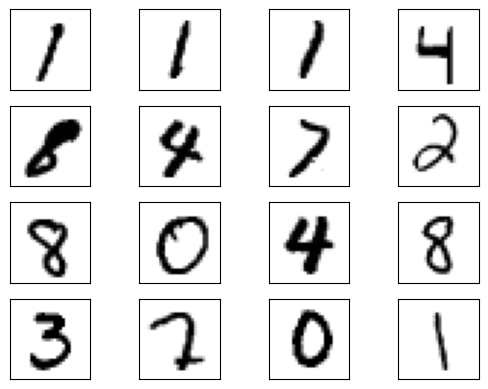

In [16]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [18]:
discriminator = Discriminator().to(device=device)

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [20]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [21]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5909656286239624
Epoch: 0 Loss G.: 0.4715695381164551
Epoch: 1 Loss D.: 0.0357867032289505
Epoch: 1 Loss G.: 5.258911609649658
Epoch: 2 Loss D.: 0.09254839271306992
Epoch: 2 Loss G.: 7.411188125610352
Epoch: 3 Loss D.: 0.09870167076587677
Epoch: 3 Loss G.: 4.453644752502441
Epoch: 4 Loss D.: 0.08042796701192856
Epoch: 4 Loss G.: 5.645044326782227
Epoch: 5 Loss D.: 0.17184852063655853
Epoch: 5 Loss G.: 3.4200215339660645
Epoch: 6 Loss D.: 0.214980348944664
Epoch: 6 Loss G.: 2.528867721557617
Epoch: 7 Loss D.: 0.28020766377449036
Epoch: 7 Loss G.: 1.8628180027008057
Epoch: 8 Loss D.: 0.2613140344619751
Epoch: 8 Loss G.: 2.7235469818115234
Epoch: 9 Loss D.: 0.33811452984809875
Epoch: 9 Loss G.: 1.8737174272537231
Epoch: 10 Loss D.: 0.2991078495979309
Epoch: 10 Loss G.: 1.679195761680603
Epoch: 11 Loss D.: 0.33481183648109436
Epoch: 11 Loss G.: 1.8840312957763672
Epoch: 12 Loss D.: 0.43695905804634094
Epoch: 12 Loss G.: 1.426808476448059
Epoch: 13 Loss D.: 0.36029693484

In [22]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

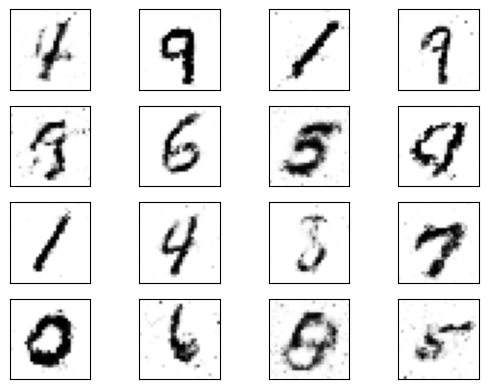

In [23]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])